In [163]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display
from skimage.draw import line
from math import sqrt



# read data

In [103]:
dataset_dir = "/home/vladushked/Documents/data/leolab_grasping_dataset/plastic/bottles"

background_path = os.path.join(dataset_dir, "background.png")

rgbs = glob.glob(os.path.join(dataset_dir, "pcd????r.png"))
depths = glob.glob(os.path.join(dataset_dir, "pcd????d.tiff"))
poss = glob.glob(os.path.join(dataset_dir, "pcd????cpos.txt"))
bboxes = glob.glob(os.path.join(dataset_dir, "pcd????bbox.txt"))
contours = glob.glob(os.path.join(dataset_dir, "pcd????cont.txt"))
meanlines = glob.glob(os.path.join(dataset_dir, "pcd????meanline.txt"))
minboxes = glob.glob(os.path.join(dataset_dir, "pcd????minbox.txt"))

rgbs.sort()
depths.sort()
poss.sort()
bboxes.sort()
contours.sort()
meanlines.sort()
minboxes.sort()

# Visualize

In [129]:
i = 30
colors = [list(np.random.random(size=3) * 256) for _ in range(20)]

In [130]:
rgb = cv2.imread(rgbs[i])
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) 
print("RGB: ", os.path.split(rgbs[i])[-1])

depth = Image.open(depths[i])
# im.show()
depth = np.array(depth)

rows,cols = rgb.shape[:2]

pos_points = np.genfromtxt(poss[i], dtype="float")
pos_points = pos_points.reshape(-1, 4, 2).astype(int)

bbox = np.genfromtxt(bboxes[i], dtype="int")
contour = np.genfromtxt(contours[i], dtype="int")
[vx,vy,x,y] = np.genfromtxt(meanlines[i], dtype="float")
minbox = np.genfromtxt(minboxes[i], dtype="int")


RGB:  pcd0031r.png


In [131]:
def crop_bbox(img,bbox,margin=50):
    img = img.copy()
    [left, top] = bbox[0] - margin
    [right, bottom] = bbox[1] + margin
    return img[top:bottom, left:right]

In [132]:
def normalize(depth):
    copy = depth.copy()
    return (copy - np.min(copy)) / (np.max(copy) - np.min(copy))

In [158]:
def draw_line(img, vx,vy,x,y):
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    # cv2.line(img,(cols-1,righty),(0,lefty),(255,255,0),2)
    return lefty, righty

Depth max min:  33.109 0.0
Depth normalized max min:  1.0 0.0
Depth cropped normalized max min:  1.0 0.0


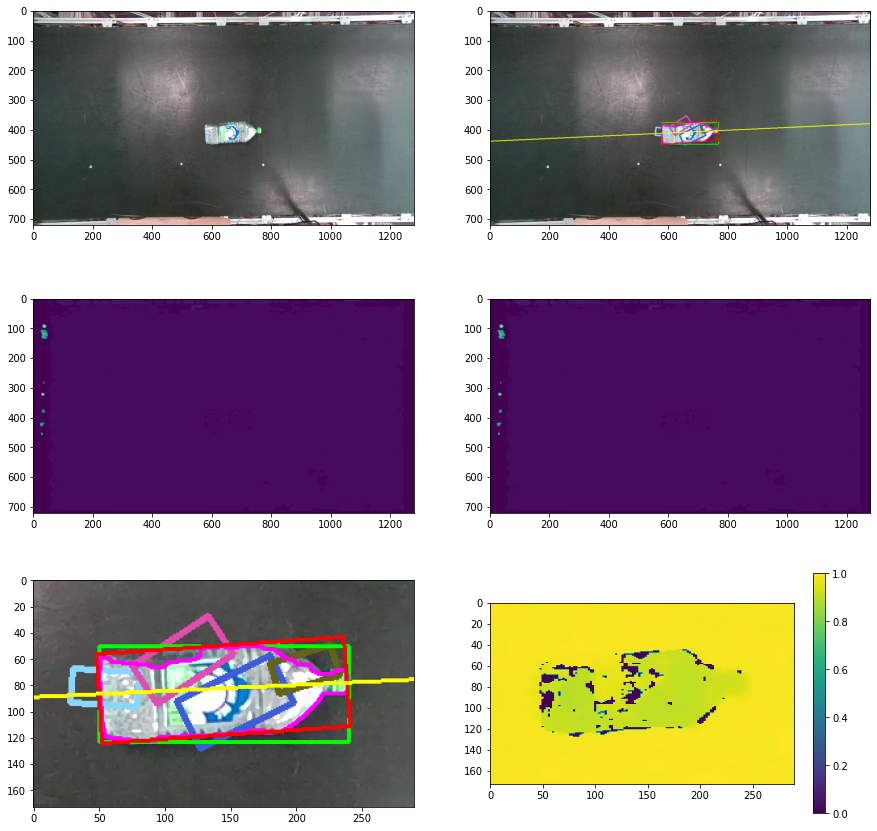

In [134]:
rgb_copy = rgb.copy()
depth_copy = depth.copy()
normalized_depth = normalize(depth_copy)
cropped_normalized_depth = normalize(crop_bbox(depth_copy, bbox))

print("Depth max min: ", depth_copy.max(), depth_copy.min())
print("Depth normalized max min: ", normalized_depth.max(), normalized_depth.min())
print("Depth cropped normalized max min: ", cropped_normalized_depth.max(), cropped_normalized_depth.min())

for i, rect in enumerate(pos_points):
    cv2.drawContours(rgb_copy, [rect], 0, color=colors[i], thickness=4)

cv2.rectangle(rgb_copy,(bbox[0]),(bbox[1]),(0,255,0),2)

cv2.drawContours(rgb_copy, [contour], -1, (255, 0, 255), 2)
cv2.drawContours(rgb_copy,[minbox],0,(255,0,0),2, cv2.FILLED)

lefty, righty = draw_line(rgb_copy,vx,vy,x,y)

cropped_rgb = crop_bbox(rgb_copy, bbox)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

axes[0,0].imshow(rgb)
axes[0,1].imshow(rgb_copy)
axes[1,0].imshow(depth)
axes[1,1].imshow(normalized_depth)
axes[2,0].imshow(cropped_rgb)
plot = axes[2,1].imshow(cropped_normalized_depth)
plt.colorbar(plot)

# generate grasps

In [135]:
def find_intersection(img, x1,y1,x2,y2, contour):
    points = []
    for (pt1, pt2) in zip(*line(x1,y1,x2,y2)):
        point = (int(pt1), int(pt2))
        if cv2.pointPolygonTest(contour, point, False) == 0:  # If the point is on the contour
            cv2.circle(rgb_copy, point, 2, (0, 0, 255), 2)
            points.append(point)
    return points

[(766, 404), (578, 412)]


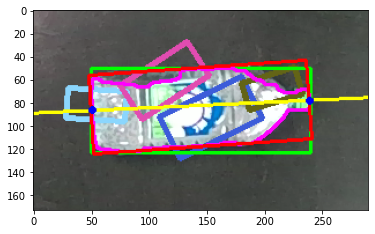

In [136]:
rgb_copy = rgb_copy.copy()

points = find_intersection(rgb_copy, cols-1,righty,0,lefty, contour)

cropped_rgb = crop_bbox(rgb_copy, bbox)
plt.imshow(cropped_rgb)
print(points)

In [181]:
def distance(first, second):
    return sqrt((first[0] - second[0]) ** 2 + (first[1] - second[1]) ** 2)

In [167]:
divider = distance(points[0], points[0]) / 40

dx = (points[1][0] - points[0][0]) / divider
dy = (points[1][1] - points[0][1]) / divider


In [168]:
divider

6.116473657263636

In [138]:
def perpendicular( a ) :
    a = np.array(a)
    a = a/np.linalg.norm(a)
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

-0.9986661267082695 0.051633006551067194


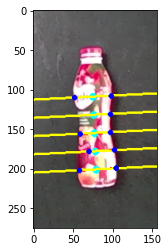

In [145]:
rgb_copy = rgb_copy.copy()
grab_center_points = []
grab_widths_points = []
pvx, pvy = perpendicular((vx,vy))
print(pvx,pvy)

for i in range(1, divider):
    point = (int( points[0][0] + dx*i), int( points[0][1] + dy*i))
    grab_center_points.append(point)
    cv2.circle(rgb_copy, point, 2, (0, 255, 255), 6)
    lefty, righty = draw_line(rgb_copy, pvx, pvy, point[0], point[1])
    widths_points = find_intersection(rgb_copy, cols-1,righty,0,lefty, contour)
    if len(widths_points) < 2:
        continue
    grab_widths_points.append(widths_points)

cropped_rgb = crop_bbox(rgb_copy, bbox)
plt.imshow(cropped_rgb)

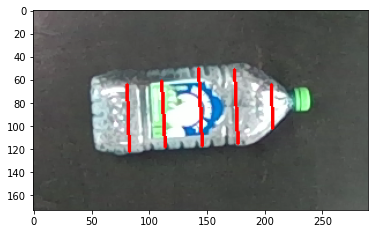

In [140]:
rgb_copy = rgb.copy()
for grab in grab_widths_points:
    cv2.line(rgb_copy,grab[0],grab[1],(255,0,0),2)

cropped_rgb = crop_bbox(rgb_copy, bbox)
plt.imshow(cropped_rgb)

In [184]:
for i in range(0, len(rgbs), 20):
    if i > len(rgbs):
        break
    rgb = cv2.imread(rgbs[i])
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) 
    depth = Image.open(depths[i])
    # im.show()
    depth = np.array(depth)
    rows,cols = rgb.shape[:2]
    pos_points = np.genfromtxt(poss[i], dtype="float")
    pos_points = pos_points.reshape(-1, 4, 2).astype(int)
    bbox = np.genfromtxt(bboxes[i], dtype="int")
    contour = np.genfromtxt(contours[i], dtype="int")
    [vx,vy,x,y] = np.genfromtxt(meanlines[i], dtype="float")
    minbox = np.genfromtxt(minboxes[i], dtype="int")

    rgb_copy = rgb.copy()
    depth_copy = depth.copy()
    normalized_depth = normalize(depth_copy)
    cropped_normalized_depth = normalize(crop_bbox(depth_copy, bbox))

    cv2.rectangle(rgb_copy,(bbox[0]),(bbox[1]),(0,255,0),2)

    cv2.drawContours(rgb_copy, [contour], -1, (255, 0, 255), 2)
    cv2.drawContours(rgb_copy,[minbox],0,(255,0,0),2, cv2.FILLED)
    lefty, righty = draw_line(rgb_copy,vx,vy,x,y)

    points = find_intersection(rgb_copy, cols-1,righty,0,lefty, contour)

    divider = int(distance(points[0], points[1]) / 20)
    if divider == 0:
        continue
    print("divider", divider)
    print("distance(points[0], points[1])", distance(points[0], points[1]))
    dx = (points[1][0] - points[0][0]) / divider
    dy = (points[1][1] - points[0][1]) / divider

    grab_center_points = []
    grab_widths_points = []
    pvx, pvy = perpendicular((vx,vy))

    for idiv in range(1, int(divider)):
        point = (int( points[0][0] + dx*idiv), int( points[0][1] + dy*idiv))
        grab_center_points.append(point)
        cv2.circle(rgb_copy, point, 2, (0, 255, 255), 6)
        lefty, righty = draw_line(rgb_copy, pvx, pvy, point[0], point[1])
        widths_points = find_intersection(rgb_copy, cols-1,righty,0,lefty, contour)
        if len(widths_points) < 2:
            continue
        grab_widths_points.append(widths_points)

    # rgb_copy = rgb.copy()
    for grab in grab_widths_points:
        cv2.line(rgb_copy,grab[0],grab[1],(0,255,255),2)
    for point in grab_center_points:
        cv2.circle(rgb_copy, point, 2, (0, 0, 255), 2)

    cropped_rgb = crop_bbox(rgb_copy, bbox)
    name = "out/img%d.jpg" % i
    print(name)
    cropped_rgb = cv2.cvtColor(cropped_rgb, cv2.COLOR_RGB2BGR) 
    cv2.imwrite(name, cropped_rgb)

divider 6
distance(points[0], points[1]) 124.4025723206719
out/img0.jpg
divider 8
distance(points[0], points[1]) 173.80736463107655
out/img20.jpg
divider 7
distance(points[0], points[1]) 159.8311609167624
out/img40.jpg
divider 6
distance(points[0], points[1]) 139.5886814895821
out/img60.jpg
divider 7
distance(points[0], points[1]) 142.01408380861386
out/img80.jpg
divider 7
distance(points[0], points[1]) 145.7737973711325
out/img100.jpg
divider 9
distance(points[0], points[1]) 185.88437266214714
out/img120.jpg
divider 2
distance(points[0], points[1]) 46.2709412050371
out/img160.jpg


/tmp/ipykernel_11659/3860138632.py:10: UserWarning: genfromtxt: Empty input file: "/home/vladushked/Documents/data/leolab_grasping_dataset/plastic/bottles/pcd0141cpos.txt"
  pos_points = np.genfromtxt(poss[i], dtype="float")
/tmp/ipykernel_11659/3860138632.py:10: UserWarning: genfromtxt: Empty input file: "/home/vladushked/Documents/data/leolab_grasping_dataset/plastic/bottles/pcd0161cpos.txt"
  pos_points = np.genfromtxt(poss[i], dtype="float")
/tmp/ipykernel_11659/3860138632.py:10: UserWarning: genfromtxt: Empty input file: "/home/vladushked/Documents/data/leolab_grasping_dataset/plastic/bottles/pcd0181cpos.txt"
  pos_points = np.genfromtxt(poss[i], dtype="float")


divider 7
distance(points[0], points[1]) 157.26728839781018
out/img180.jpg
divider 6
distance(points[0], points[1]) 138.1774221788784
out/img200.jpg
divider 8
distance(points[0], points[1]) 161.02794788483146
out/img220.jpg
divider 7
distance(points[0], points[1]) 159.31415505221122
out/img240.jpg
divider 9
distance(points[0], points[1]) 181.0
out/img260.jpg
divider 6
distance(points[0], points[1]) 139.2300254973761
out/img280.jpg
